In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d, RectBivariateSpline,RegularGridInterpolator,interp1d,PchipInterpolator
import matplotlib.path as mpath
from tqdm import tqdm
import copy

In [2]:
def read_am_file(file_path):    
    # Search for the binary data section marker "@1"
    marker = b"@1"
    with open(file_path, 'rb') as file:
        content = file.read()
        start = content.find(marker) + len(marker)
        
        # Assuming there are two newline characters after the "@1" marker
        # Adjust if necessary based on the actual file format
        start += 32
        
        # The total number of data points is the product of the lattice dimensions
        # Each point has 2 float components
        num_points = 512 * 512 * 1001 * 2
        
        # Set the file pointer to the start of the binary data and read it
        file.seek(start)
        data = np.fromfile(file, dtype=np.float32)
        
        # Reshape the data to the correct dimensions (512, 512, 1001, 2)
        # The last dimension is 2 for the two components of velocity at each grid point
        data = data.reshape((1001,512, 512, 2))
        return data

file_path = r'TrainingData/TurbulentFlowData/0500.am'
data = read_am_file(file_path)

dx = 1.0/513
dy = 1.0/513
dvdx = np.gradient(data[:,:,:,0], axis=1)/dx
dudy = np.gradient(data[:,:,:,1], axis=2)/dy
w = dvdx - dudy

(array([13637., 30480., 43903., 36445., 38054., 20746., 16868., 18295.,
        26278., 17438.]),
 array([-5.56307459, -4.35903549, -3.15499616, -1.95095706, -0.74691784,
         0.45712137,  1.66116059,  2.8651998 ,  4.06923914,  5.27327824,
         6.47731733]),
 <BarContainer object of 10 artists>)

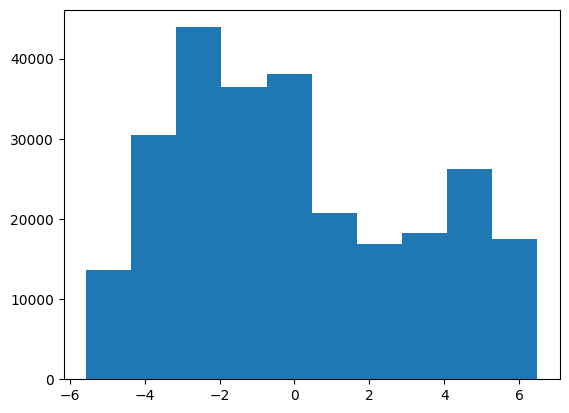

In [42]:
plt.hist(dudy[100,:,:].flatten(), bins=10)

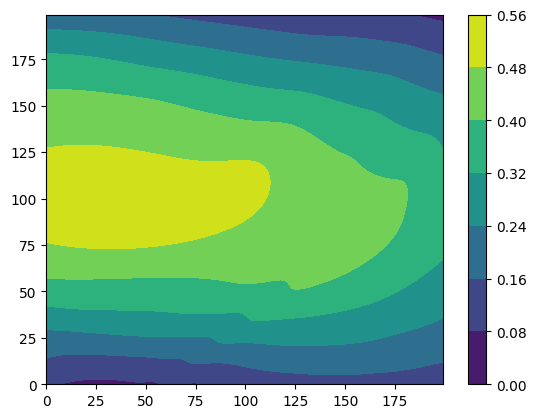

In [11]:
plt.contourf(data[700,200:400,200:400,0])
plt.colorbar()

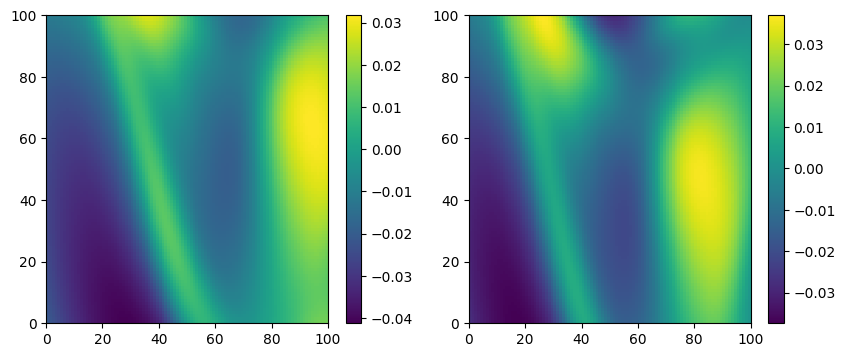

In [23]:
idx = 510
didx = 10
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.pcolormesh(data[idx+didx,:100,:100,1]-data[idx,:100,:100,1])
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(data[idx+2*didx,:100,:100,1]-data[idx+didx,:100,:100,1])
plt.colorbar()

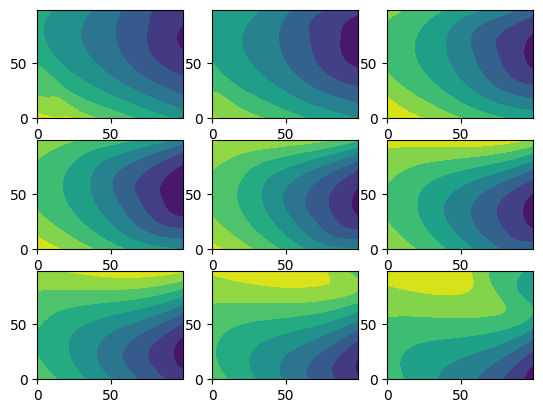

In [28]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.contourf(data[400+10*i,:100,:100,0])

In [34]:
class IsInDomain:
    def __init__(self, nodesCurves):
        self.loops = [mpath.Path(nodesCurves[i]) for i in range(len(nodesCurves))]
        
    def __call__(self, points):
        return np.logical_and(self.loops[0].contains_points(points),np.logical_not(np.array([loop.contains_points(points) for loop in self.loops[1:]]).any(0)))
    
class Interp2dAcrossTimesteps:
    def __init__(self, data, x_coords, y_coords, kind='linear'):
        # self.data = data
        # self.x_coords = x_coords
        # self.y_coords = y_coords
        self.interp = [RegularGridInterpolator((x_coords,y_coords),  np.transpose(data[i,:,:,:],(1,0,2)), method=kind, bounds_error=False, fill_value=None) for i in range(data.shape[0])]

    def __call__(self, points, timesteps):
        return np.stack([self.interp[timestep](points) for timestep in timesteps],0)
    
class Interp2Dslice:
    def __init__(self, interp2dAT, dT_arr):
        self.interp2dAT = interp2dAT
        self.dT_arr = dT_arr
        self.nDims = len(dT_arr)*2
    
    def __call__(self, points):
        return self.interp2dAT(points, self.dT_arr)
        
# d_IE = data[0]['interpSE'].nDims
# d_BE = data[0]['interpBS'][0].spline.c.shape[-1]
# d_D = data[0]['interpSD'].nDims
    
class Interp1DPeriodic:
    def __init__(self, x, y, kind = 'linear'):
        self.x = x
        self.y = y
        self.kind = kind
        self.spline = interp1d(self.x,self.y,kind=self.kind,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
class Interp1DPchipPeriodic:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.spline = PchipInterpolator(self.x,self.y,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])

class Interp1dAcrossTimesteps:
    def __init__(self, dataB, distance, kind='pchip'):
        if kind == 'pchip':
            self.interp = [Interp1DPchipPeriodic(distance, dataB[i]) for i in range(dataB.shape[0])]
        else:
            self.interp = [Interp1DPeriodic(distance, dataB[i],kind=kind) for i in range(dataB.shape[0])]

    def __call__(self, x, timesteps):
        return np.stack([self.interp[timestep](x) for timestep in timesteps],0)
    
class Interp1Dslice:
    def __init__(self, interp1dAT, dT_arr):
        self.interp1dAT = interp1dAT
        self.dT_arr = dT_arr
        self.nDims = len(dT_arr)*2
    
    def __call__(self, x):
        return self.interp1dAT(x, self.dT_arr)

# input: file_path,dT_arr
def loadData(file_path, dT_arr):
    data = read_am_file(file_path)

    NT = data.shape[0]
    NX = data.shape[1]
    NY = data.shape[2]
    Nv = data.shape[3]

    x = np.linspace(0, 1, NX)
    X,Y = np.meshgrid(x, x)

    # Comon for all timesteps
    nodes = np.stack([X.flatten(),Y.flatten()],-1)
    idxCorner = np.array([0,NX-1,NX*(NY-1),NX*NY-1],dtype=int)
    elementsBoundaryNodesOnly = np.array([[idxCorner[0],idxCorner[2],idxCorner[1]],[idxCorner[2],idxCorner[3],idxCorner[1]]],dtype=int)
    areaElementsBoundaryNodesOnly = np.array([0.5,0.5])
    isInDomain = IsInDomain([nodes[[idxCorner[0],idxCorner[1],idxCorner[3],idxCorner[2],idxCorner[0]]]])
    idxCurves = [np.concatenate([np.arange(NX),np.arange(2*NX-1,NY*NX,NX),np.arange(NY*NX-2,(NY-1)*NX-1,-1),np.arange((NY-2)*NX,-1,-NX)])]
    distance = [np.arange(0,idxCurve.shape[0])*1.0/(NX-1) for idxCurve in idxCurves]
    lengthCurves = [4]
    nodesCurves = [nodes[idxCurve] for idxCurve in idxCurves]
    idxCurveCorner = np.array([0,0,0,0],dtype=int)
    distanceCornerCurve = np.array([0,1,3,2],dtype=int)
    distance2boundary = np.min(np.stack([np.abs(X),np.abs(X-1),np.abs(Y),np.abs(Y-1)],-1),-1)
    interpD2B = RegularGridInterpolator((x,x),distance2boundary, method='linear', bounds_error=False, fill_value=None)
    interpBC = [Interp1DPeriodic(distance[0],nodesCurves[0],kind='linear')]
    normalCurves = [np.zeros((idxCurves[0].shape[0],2))]
    normalCurves[0][nodesCurves[0][:,0]==0,0] = -1
    normalCurves[0][nodesCurves[0][:,0]==1,0] = 1
    normalCurves[0][nodesCurves[0][:,1]==0,1] = -1
    normalCurves[0][nodesCurves[0][:,1]==1,1] = 1
    normalCurves[0] = normalCurves[0]/np.sqrt(np.sum(normalCurves[0]**2,1,keepdims=True))
    interpBN = [Interp1DPeriodic(distance[0],normalCurves[0],kind='linear')]

    interp2dAcrossTimesteps = Interp2dAcrossTimesteps(data, x, x)
    dataB = [data.reshape((NT,NX*NY,Nv))[:,idxCurves[0],:]]
    interp1dAcrossTimesteps = [Interp1dAcrossTimesteps(dataB[0], distance[0], kind='pchip')]

    data_processed = []
    for i in range(-dT_arr[0],NT-dT_arr[-1]):
        # interpSE = lambda points, idxs = dT_arr+i: interp2dAcrossTimesteps(points, idxs)
        # interpSD = lambda points, idxs = [i]: interp2dAcrossTimesteps(points, idxs)
        interpSE = Interp2Dslice(interp2dAcrossTimesteps, dT_arr+i)
        interpSD = Interp2Dslice(interp2dAcrossTimesteps, [i])
        # interpBS = [lambda x,idxs=dT_arr+i: interp1dAcrossTimesteps[0](x, idxs)]
        interpBS = [Interp1Dslice(interp1dAcrossTimesteps[0], dT_arr+i)]
        data_processed.append(
            {'nodes': nodes,'elementsBoundaryNodesOnly': elementsBoundaryNodesOnly,'areaElementsBoundaryNodesOnly': areaElementsBoundaryNodesOnly,
            'isInDomain': isInDomain,'interpSE': interpSE,'interpSD': interpSD,'interpD2B': interpD2B,'nodesCurves': nodesCurves,
            'lengthCurves': lengthCurves,'interpBC': interpBC,'interpBS': interpBS,'interpBN': interpBN,
            'distanceCornerCurve': distanceCornerCurve, 'idxCurveCorner': idxCurveCorner, 'dT': i}
        )

    return data_processed

file_path = r'TrainingData/TurbulentFlowData/0500.am'
data_processed = loadData(file_path, np.arange(-50,1,5))

In [73]:
dT_arr = np.arange(-50,1,5)

data = read_am_file(file_path)

NT = data.shape[0]
NX = data.shape[1]
NY = data.shape[2]
Nv = data.shape[3]

x = np.linspace(0, 1, NX)
X,Y = np.meshgrid(x, x)

# Comon for all timesteps
nodes = np.stack([X.flatten(),Y.flatten()],-1)
idxCorner = np.array([0,NX-1,NX*(NY-1),NX*NY-1],dtype=int)
elementsBoundaryNodesOnly = np.array([[idxCorner[0],idxCorner[2],idxCorner[1]],[idxCorner[2],idxCorner[3],idxCorner[1]]],dtype=int)
areaElementsBoundaryNodesOnly = np.array([0.5,0.5])
isInDomain = IsInDomain([nodes[[idxCorner[0],idxCorner[1],idxCorner[3],idxCorner[2],idxCorner[0]]]])
idxCurves = [np.concatenate([np.arange(NX),np.arange(2*NX-1,NY*NX,NX),np.arange(NY*NX-2,(NY-1)*NX-1,-1),np.arange((NY-2)*NX,-1,-NX)])]
distance = [np.arange(0,idxCurve.shape[0])*1.0/(NX-1) for idxCurve in idxCurves]
lengthCurves = [4]
nodesCurves = [nodes[idxCurve] for idxCurve in idxCurves]
idxCurveCorner = np.array([0,0,0,0],dtype=int)
distanceCornerCurve = np.array([0,1,3,2],dtype=int)
distance2boundary = np.min(np.stack([np.abs(X),np.abs(X-1),np.abs(Y),np.abs(Y-1)],-1),-1)
interpD2B = RegularGridInterpolator((x,x),distance2boundary, method='linear', bounds_error=False, fill_value=None)
interpBC = [Interp1DPeriodic(distance[0],nodesCurves[0],kind='linear')]
normalCurves = [np.zeros((idxCurves[0].shape[0],2))]
normalCurves[0][nodesCurves[0][:,0]==0,0] = -1
normalCurves[0][nodesCurves[0][:,0]==1,0] = 1
normalCurves[0][nodesCurves[0][:,1]==0,1] = -1
normalCurves[0][nodesCurves[0][:,1]==1,1] = 1
normalCurves[0] = normalCurves[0]/np.sqrt(np.sum(normalCurves[0]**2,1,keepdims=True))
interpBN = [Interp1DPeriodic(distance[0],normalCurves[0],kind='linear')]

interp2dAcrossTimesteps = Interp2dAcrossTimesteps(data, x, x)
dataB = [data.reshape((NT,NX*NY,Nv))[:,idxCurves[0],:]]
nodesB = [nodes[idxCurves[0]]]
nodesB_offset = [nodesB[0]-normalCurves[0]*1.0/(NX-1)]
dataB_offset = [interp2dAcrossTimesteps(nodesB_offset[0], np.arange(NT))]
dataB_dn = [(dataB[0]-dataB_offset[0])*(NX-1)*0.7]
dataB = [np.concatenate([dataB[0],dataB_dn[0]],-1)]
interp1dAcrossTimesteps = [Interp1dAcrossTimesteps(dataB[0], distance[0], kind='pchip')]

data_processed = []
for i in range(-dT_arr[0],NT-dT_arr[-1]):
    # interpSE = lambda points, idxs = dT_arr+i: interp2dAcrossTimesteps(points, idxs)
    # interpSD = lambda points, idxs = [i]: interp2dAcrossTimesteps(points, idxs)
    interpSE = Interp2Dslice(interp2dAcrossTimesteps, dT_arr+i)
    interpSD = Interp2Dslice(interp2dAcrossTimesteps, [i])
    # interpBS = [lambda x,idxs=dT_arr+i: interp1dAcrossTimesteps[0](x, idxs)]
    interpBS = [Interp1Dslice(interp1dAcrossTimesteps[0], dT_arr+i)]
    data_processed.append(
        {'nodes': nodes,'elementsBoundaryNodesOnly': elementsBoundaryNodesOnly,'areaElementsBoundaryNodesOnly': areaElementsBoundaryNodesOnly,
        'isInDomain': isInDomain,'interpSE': interpSE,'interpSD': interpSD,'interpD2B': interpD2B,'nodesCurves': nodesCurves,
        'lengthCurves': lengthCurves,'interpBC': interpBC,'interpBS': interpBS,'interpBN': interpBN,
        'distanceCornerCurve': distanceCornerCurve, 'idxCurveCorner': idxCurveCorner, 'dT': i}
    )

In [72]:
np.std(dataB_dn[0].flatten())

0.9855855517530492

(array([   6946.,   54437.,  163953.,  383741., 1449186., 1446111.,
         374336.,  155638.,   52844.,    6898.]),
 array([-3.01364515e+00, -2.41088623e+00, -1.80812732e+00, -1.20536840e+00,
        -6.02609482e-01,  1.49434432e-04,  6.02908351e-01,  1.20566727e+00,
         1.80842618e+00,  2.41118510e+00,  3.01394402e+00]),
 <BarContainer object of 10 artists>)

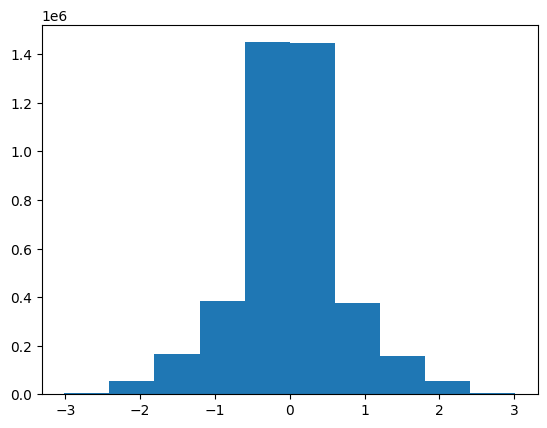

In [66]:
plt.hist(dataB_dn[0].flatten()/2, bins=10)

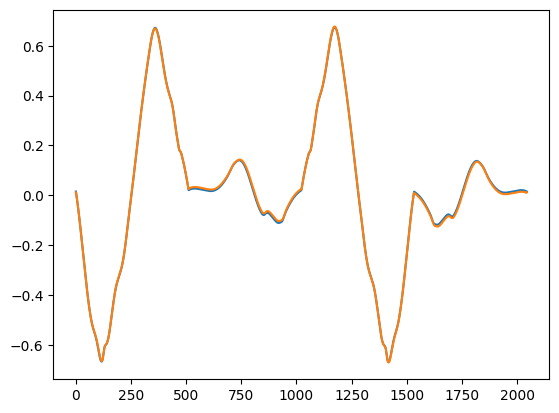

In [64]:
plt.plot(dataB[0][500,:,1])
plt.plot(dataB_offset[0][500,:,1])

In [52]:
%matplotlib qt
plt.plot(nodesB[0][:,0],nodesB[0][:,1],'-o')
plt.plot(nodesB_offset[0][:,0],nodesB_offset[0][:,1],'-o')

In [389]:
d = np.linspace(0,4,1001)
idxT = 120
nodesB_test = data_processed[idxT]['interpBC'][0](d)
# valB_test = interp1dAcrossTimesteps[0](d, [100])
valB_test = data_processed[idxT]['interpBS'][0](d)
iT = data_processed[idxT]['dT']

X,Y = np.meshgrid(np.linspace(0,1,100),np.linspace(0,1,100))
points = np.stack([X.flatten(),Y.flatten()],-1)
val_test = data_processed[idxT]['interpSE'](points)

NT = data.shape[0]
NX = data.shape[1]
NY = data.shape[2]
Nv = data.shape[3]

x = np.linspace(0, 1, NX)
X,Y = np.meshgrid(x, x)

# Comon for all timesteps
nodes = np.stack([X.flatten(),Y.flatten()],-1)
dataB = [data.reshape((NT,NX*NY,Nv))[:,idxCurves[0],:]]
interp1dAcrossTimesteps = [Interp1dAcrossTimesteps(dataB[0], distance[0], kind='pchip')]

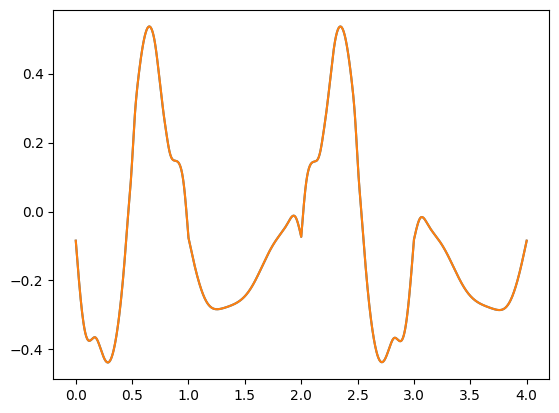

In [391]:
plt.plot(d,valB_test[0,:,1])
plt.plot(distance[0],dataB[0][120,:,1])

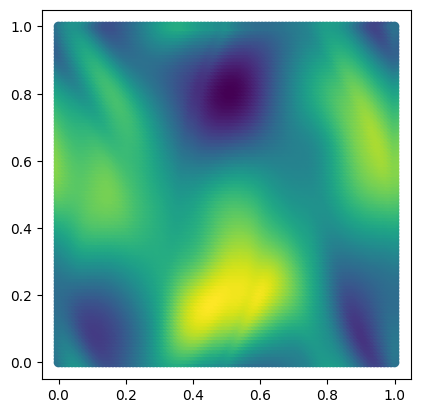

In [395]:
plt.scatter(points[:,0],points[:,1],c=val_test[4,:,0])
plt.gca().set_aspect('equal', adjustable='box')

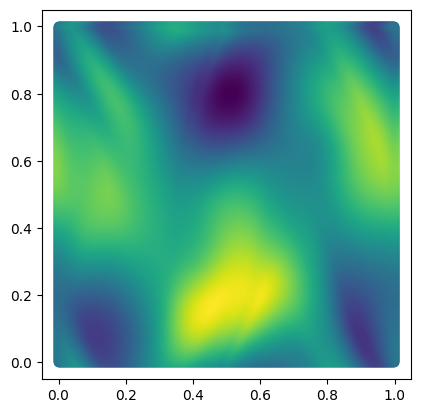

In [394]:
nodes = data_processed[0]['nodes']
plt.scatter(nodes[:,0],nodes[:,1],c=data[140, :, :, 0].flatten())
plt.gca().set_aspect('equal', adjustable='box')

In [3]:
import numpy as np
A = np.array([[0.3,0.54],
              [0.54,1.175]])
b = np.array([[1/3],[0.6]])
np.linalg.solve(A,b)

array([[ 1.11111111e+00],
       [-4.04711841e-16]])